In [ ]:

# https://www.kaggle.com/code/boramlee0418/eurosat-resnet-classifier

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms as T
import torchvision.models as models

import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import OneCycleLR
DATA_ROOT = pathlib.Path("/kaggle/input/eurosat-dataset/EuroSAT/")

train_df = pd.read_csv(DATA_ROOT / "train.csv", index_col=0).reset_index(drop=True)
valid_df = pd.read_csv(DATA_ROOT / "validation.csv", index_col=0).reset_index(drop=True)
test_df = pd.read_csv(DATA_ROOT / "test.csv", index_col=0).reset_index(drop=True)
train_df.head()

,Filename,Label,ClassName
0,AnnualCrop/AnnualCrop_142.jpg,0,AnnualCrop
1,HerbaceousVegetation/HerbaceousVegetation_2835...,2,HerbaceousVegetation
2,PermanentCrop/PermanentCrop_1073.jpg,6,PermanentCrop
3,Industrial/Industrial_453.jpg,4,Industrial
4,HerbaceousVegetation/HerbaceousVegetation_1810...,2,HerbaceousVegetation


In [3]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms as T
import pandas as pd
import pathlib

DATA_ROOT = pathlib.Path("/kaggle/input/eurosat-dataset/EuroSAT/")


class EuroSATDataset(Dataset):
    def __init__(self, annotation_df, train: bool = False):
        """
        Custom dataset for EuroSAT.
        If train=True, apply data augmentation.
        """
        self.df = annotation_df
        self.train = train

        if train:
            self.transform = T.Compose([
                T.ConvertImageDtype(torch.float32),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomRotation(20),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = T.Compose([
                T.ConvertImageDtype(torch.float32),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        img_path = (DATA_ROOT / sample["Filename"]).as_posix()
        img = read_image(img_path)
        img = self.transform(img)
        label = torch.tensor(sample["Label"])
        return img, label

In [6]:
import multiprocessing
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tv_models
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim
import torch


class EuroSATLightningDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 64, num_workers: int = 3):
        """
        Lightning DataModule wrapping EuroSAT datasets and dataloaders.
        """
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        """
        Prepare datasets for different stages.
        """
        self.train_data = EuroSATDataset(train_df, train=True)
        self.valid_data = EuroSATDataset(valid_df, train=False)
        self.test_data = EuroSATDataset(test_df, train=False)

    def _loader(self, dataset, shuffle: bool = False):
        """
        Helper function to create dataloaders.
        """
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=shuffle,
        )

    def train_dataloader(self):
        return self._loader(self.train_data, shuffle=True)

    def val_dataloader(self):
        return self._loader(self.valid_data)

    def test_dataloader(self):
        return self._loader(self.test_data)

    def predict_dataloader(self):
        return self._loader(self.test_data)


class EuroSATLightningModule(pl.LightningModule):
    def __init__(self, num_classes: int = 10, lr: float = 3e-4):
        """
        LightningModule for fine-tuning ResNet-50 on EuroSAT.
        """
        super().__init__()
        self.save_hyperparameters()
        self.num_classes = num_classes
        self.lr = lr

        # Load ResNet-50 pretrained weights (local version)
        local_weight_path = "/kaggle/input/resnet50/resnet50-11ad3fa6.pth"
        self.model = tv_models.resnet50(weights=None)
        state = torch.load(local_weight_path, map_location="cpu")
        self.model.load_state_dict(state)

        # Replace the final FC layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        # ADDED: container for LR logging
        self.lr_list = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=self.num_classes)

        # Log epoch-level metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        # ADDED: log LR at each step
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        self.lr_list.append(lr)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=self.num_classes)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = accuracy(logits, y, task="multiclass", num_classes=self.num_classes)

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
    
        # Lightning automatically estimates total steps correctly
        total_steps = self.trainer.estimated_stepping_batches
    
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.lr,
            total_steps=total_steps,
        )
    
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [7]:
import time
import json
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar, Timer

# Start timer
start_time = time.time()

datamodule = EuroSATLightningDataModule(batch_size=64)
model = EuroSATLightningModule(num_classes=10, lr=3e-4)

timer = Timer(interval="epoch", verbose=True)

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu",
    devices=1,
    precision="32",
    logger=CSVLogger("logs/"),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
        RichProgressBar(),
        timer,
    ],
    log_every_n_steps=10,
)

print("Training started...")
trainer.fit(model, datamodule)

trainer.test(model, datamodule)

# ================================
# ADDED: Save LR history to file
# ================================
lr_path = f"{trainer.logger.log_dir}/lr_history.csv"
pd.DataFrame({"lr": model.lr_list}).to_csv(lr_path, index=False)

# Total time
end_time = time.time()
print("\nTotal cell execution time:")
print(f"{(end_time - start_time) / 60:.2f} minutes")

# Epoch timings
print("\nEpoch-wise timings:")
print(timer.time_elapsed())

# ============================================
# ADDED: Save final metrics to file
# ============================================
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics_path = f"{trainer.logger.log_dir}/epoch_metrics.json"
metrics.groupby("epoch").agg("last").to_json(metrics_path, indent=2)

# ADDED: Save latest epoch metrics separately
final_epoch = metrics["epoch"].max()
final_metrics = metrics.groupby("epoch").agg("last").loc[final_epoch].to_dict()

with open(f"{trainer.logger.log_dir}/final_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=2)

print("\nFinal metrics saved to final_metrics.json")

Training started...


┏━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ ResNet │ 23.5 M │
└───┴───────┴────────┴────────┘

Trainable params: 23.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9877777695655823     │
│         test_loss         │   0.048327233642339706    │
└───────────────────────────┴───────────────────────────┘


Total cell execution time:
7.28 minutes

Epoch-wise timings:
424.32384041599994

Final metrics saved to final_metrics.json


,test_acc,test_loss,train_acc,train_loss,val_acc,val_loss
epoch,,,,,,
0,NaN,NaN,0.457407,1.709690,0.889444,0.448755
1,NaN,NaN,0.922751,0.247103,0.964259,0.115830
2,NaN,NaN,0.952328,0.145537,0.972407,0.092590
3,NaN,NaN,0.962804,0.116317,0.964815,0.100248
4,NaN,NaN,0.969841,0.095593,0.969630,0.091797


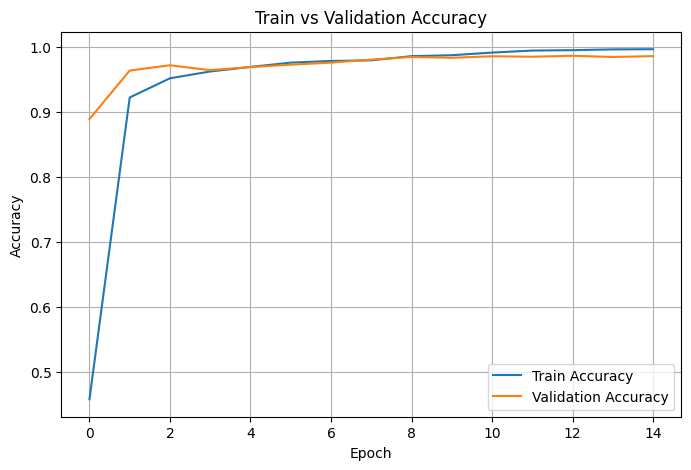


Final epoch metrics:
test_acc      0.987778
test_loss     0.048327
train_acc          NaN
train_loss         NaN
val_acc            NaN
val_loss           NaN
Name: 15, dtype: float64


<Figure size 640x480 with 0 Axes>

In [8]:
import seaborn as sn
import matplotlib.pyplot as plt

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

if "step" in metrics.columns:
    del metrics["step"]

metrics = metrics.dropna(axis=1, how="all")

epoch_metrics = metrics.groupby("epoch").agg("last")

display(epoch_metrics.head())

# Learning curve – accuracy
if {"train_acc", "val_acc"}.issubset(epoch_metrics.columns):
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_metrics.index, epoch_metrics["train_acc"], label="Train Accuracy")
    plt.plot(epoch_metrics.index, epoch_metrics["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("train_acc or val_acc not found. Check logging configuration.")

# Save learning curve
plt.savefig(f"{trainer.logger.log_dir}/learning_curve_acc.png")

# Print final metrics
final_epoch = epoch_metrics.index.max()
print("\nFinal epoch metrics:")
print(epoch_metrics.loc[final_epoch])

In [10]:
torch.save(model.state_dict(), "resnet50_eurosat_best.pth")
print("Model saved as resnet50_eurosat_best.pth")

Model saved as resnet50_eurosat_best.pth
